# Data Science Workshop

# Data Loading

## Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.linear_model as lm
from sklearn import metrics, preprocessing, svm
from sklearn.model_selection import cross_val_score

import random

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

## Reading the Income Classification Dataset

In [35]:
# read the entire file into a python array
with open('raw_data.json', 'rb') as f:
    data = f.readlines()
with open('photos.json', 'rb') as f:
    photos_data = f.readlines()
with open('feeds.json', 'rb') as f:
    feeds_data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
photos_data = map(lambda x: x.rstrip(), photos_data)
feeds_data = map(lambda x: x.rstrip(), feeds_data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"
photos_data_json_str = "[" + ','.join(photos_data) + "]"
feeds_data_json_str = "[" + ','.join(feeds_data) + "]"

# now, load it into pandas
raw_data = pd.read_json(data_json_str)
photos_raw_data = pd.read_json(photos_data_json_str)
feeds_raw_data = pd.read_json(feeds_data_json_str)

# join all data frames - used inner join to get rid of outdated pages (pages that got deleted between our queries)
raw_data = pd.merge(left=raw_data, right=photos_raw_data, how='inner', left_on='id', right_on='page_id')
raw_data = pd.merge(left=raw_data, right=feeds_raw_data, how='inner', left_on='id', right_on='page_id')

In [36]:
# read the entire file into a python array
# with open('feeds.json', 'rb') as f:
#     data = f.readlines()
# data = map(lambda x: x.rstrip(), data)
# data_json_str = "[" + ','.join(data) + "]"
# raw_data = pd.read_json(data_json_str)


# Data preparation

In [37]:
# currentLocation and current_location are too sparse and it's not clear if its a city/country etc..
ready_feats = ['has_cover_photo', 'has_profile_photo', 'id', 'likes', 

               # photo fields
               'avg_comments_per_photo', 'avg_comments_total_likes', 'avg_distinct_comments_writers', 
               'avg_likes_per_photo', 'avg_people_tagged_per_photo', 'avg_people_tagged_per_photo_with_more_than_zero', 
               'count_has_name', 'count_has_place', 'distinct_uploaders', 'number_of_albums', 'number_of_cover_albums', 
               'number_of_days_between_first_and_last_photos', 'number_of_different_months_for_photos', 
               'number_of_null_albums', 'number_of_other_albums', 'number_of_photos_in_cover_albums', 
               'number_of_photos_in_null_albums', 'number_of_photos_in_other_albums', 'number_of_photos_in_profile_albums',
               'number_of_profile_albums', 'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 
               'sum_comments_count', 'sum_like_count', 'sum_people_tagged_count', 'total_photos',
                
               # feed fields
               'feed_avg_comments', 'feed_avg_likes', 'feed_avg_people_tagged_per_post', 
               'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_avg_shares', 'feed_avg_shares_cnt', 
               'feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_count_has_place', 
               'feed_count_post_updated', 'feed_is_hidden_count', 'feed_is_published_count', 
               'feed_max_comments', 'feed_max_likes', 'feed_max_shares', 'feed_max_shares_cnt', 
               'feed_min_comments', 'feed_min_likes', 'feed_min_shares', 'feed_min_shares_cnt', 
               'feed_number_of_added_photos_posts', 'feed_number_of_days_between_first_and_last_posts', 
               'feed_number_of_different_months_for_post', 'feed_number_of_null_albums', 'feed_number_of_other_posts', 
               'feed_number_of_shared_story_posts', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
               'feed_post_updated_prc', 'feed_std_comments', 'feed_std_likes', 'feed_std_shares', 'feed_std_shares_cnt', 
               'feed_sum_people_tagged_count', 'feed_sum_with_tagged_count', 'post_count'              
              ]

all_data = raw_data[ready_feats].copy()

# merge identical columns
all_data['general_info'] = pd.concat([raw_data['generalInfo'].dropna(), raw_data['general_info'].dropna()]).reindex_like(raw_data)
all_data['is_permanently_closed'] = pd.concat([raw_data['isPermanentlyClosed'].dropna(), raw_data['is_permanently_closed'].dropna()]).reindex_like(raw_data)
all_data['is_unclaimed'] = pd.concat([raw_data['isUnclaimed'].dropna(), raw_data['is_unclaimed'].dropna()]).reindex_like(raw_data)
all_data['is_verified'] = pd.concat([raw_data['isVerified'].dropna(), raw_data['is_verified'].dropna()]).reindex_like(raw_data)
all_data['price_range'] = pd.concat([raw_data['priceRange'].dropna(), raw_data['price_range'].dropna()]).reindex_like(raw_data)
all_data['start_info'] = pd.concat([raw_data['startInfo'].dropna(), raw_data['start_info'].dropna()]).reindex_like(raw_data)
all_data['talking_about_count'] = pd.concat([raw_data['talkingAboutCount'].dropna(), raw_data['talking_about_count'].dropna()]).reindex_like(raw_data)
all_data['were_here_count'] = pd.concat([raw_data['wereHereCount'].dropna(), raw_data['were_here_count'].dropna()]).reindex_like(raw_data)

# create 'has' columns
all_data['has_email'] = raw_data['emails'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_phone'] = raw_data['phone'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_website'] = raw_data['website'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_location'] = raw_data['location'].apply(lambda x: type(x) != np.float and len(x) > 0)

# create 'len' columns
all_data['description_len'] = raw_data['description'].apply(lambda x: len(x) if type(x) != np.float else np.nan)
all_data['general_info_len'] = all_data['general_info'].apply(lambda x: len(x) if type(x) != np.float else np.nan)
all_data['name_len'] = raw_data['name'].apply(lambda x: len(x) if type(x) != np.float else np.nan)
all_data['price_range'] = all_data['price_range'].apply(lambda x: len(x) if type(x) != np.float else np.nan)
all_data['products_len'] = raw_data['products'].apply(lambda x: len(x) if type(x) != np.float else np.nan)

# create 'num of words' columns
all_data['name_num_of_words'] = raw_data['name'].apply(lambda x: len(x.split()) if type(x) != np.float else np.nan)

# parse complex vars
all_data['location_city'] = raw_data['location'].apply(lambda x: x['city'] if (type(x) != np.float and 'city' in x) else np.nan)
all_data['location_city'].fillna(raw_data['hometown'], inplace=True)
all_data['location_country'] = raw_data['location'].apply(lambda x: x['country'] if (type(x) != np.float and 'country' in x) else np.nan)
all_data['start_info'] = all_data['start_info'].apply(lambda x: x['date']['year'] if (type(x) != np.float and 'date' in x and 'year' in x['date']) else np.nan)

# frequency related features - move to feature eng
all_data['photo_upload_freq'] = all_data.apply(lambda x: x['number_of_days_between_first_and_last_photos']/x['total_photos'] if x['number_of_days_between_first_and_last_photos'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
# all_data['count_has_name'] = all_data.apply(lambda x: x['count_has_name']/x['total_photos'] if x['count_has_name'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
# all_data['count_has_place'] = all_data.apply(lambda x: x['count_has_place']/x['total_photos'] if x['count_has_place'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
# all_data['distinct_uploaders'] = all_data.apply(lambda x: x['distinct_uploaders']/x['total_photos'] if x['distinct_uploaders'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
all_data['feed_update_freq'] = all_data.apply(lambda x: x['feed_number_of_days_between_first_and_last_posts']/x['post_count'] if x['feed_number_of_days_between_first_and_last_posts'] != np.nan and x['post_count'] != np.nan else 0, axis=1)

# convert types
all_data['founded'] = raw_data['founded'].apply(lambda x: np.int64(x) if (type(x) == unicode and x.strip().isdigit()) else np.nan)

# drop duplicate pages (we got some pages twice because we queried by page category and some pages were in several categrories)
all_data.drop_duplicates(subset='id', keep='last', inplace=True)

## Missing Data Imputation

In [38]:
print "Missing data by column (total rows %s):" % all_data.id.count()
missing_count = all_data.isnull().sum()
print missing_count[missing_count.nonzero()[0]]

Missing data by column (total rows 12794):
avg_people_tagged_per_photo_with_more_than_zero         7831
feed_avg_comments                                        259
feed_avg_likes                                           259
feed_avg_people_tagged_per_post_with_more_than_zero     7535
feed_avg_shares                                           98
feed_avg_with_tagged_per_post_with_more_than_zero      10722
feed_max_comments                                        259
feed_max_likes                                           259
feed_max_shares                                           98
feed_min_comments                                        259
feed_min_likes                                           259
feed_min_shares                                           98
feed_std_comments                                        280
feed_std_likes                                           280
feed_std_shares                                          207
feed_std_shares_cnt                       

In [39]:
# drop features too sparse or that have no meaningful way to fill
feats_to_drop = ['founded', 'start_info', 'general_info']
all_data.drop(feats_to_drop, axis = 1, inplace=True)

# NaN to 0
numeric_impute = [  'price_range', 'description_len', 'general_info_len', 'products_len', 'photo_upload_freq',
                    'avg_comments_per_photo', 'avg_comments_total_likes', 'avg_distinct_comments_writers', 
                    'avg_likes_per_photo', 'avg_people_tagged_per_photo', 'avg_people_tagged_per_photo_with_more_than_zero', 
                    'count_has_name', 'count_has_place', 'distinct_uploaders', 'number_of_albums', 'number_of_cover_albums', 
                    'number_of_days_between_first_and_last_photos', 'number_of_different_months_for_photos', 
                    'number_of_null_albums', 'number_of_other_albums', 'number_of_photos_in_cover_albums', 
                    'number_of_photos_in_null_albums', 'number_of_photos_in_other_albums', 'number_of_photos_in_profile_albums',
                    'number_of_profile_albums', 'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 
                    'sum_comments_count', 'sum_like_count', 'sum_people_tagged_count', 'total_photos',
                    'feed_avg_comments', 'feed_avg_likes', 'feed_avg_people_tagged_per_post', 
                    'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_avg_shares', 'feed_avg_shares_cnt', 
                    'feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_count_has_place', 
                    'feed_count_post_updated', 'feed_is_hidden_count', 'feed_is_published_count', 
                    'feed_max_comments', 'feed_max_likes', 'feed_max_shares', 'feed_max_shares_cnt', 
                    'feed_min_comments', 'feed_min_likes', 'feed_min_shares', 'feed_min_shares_cnt', 
                    'feed_number_of_added_photos_posts', 'feed_number_of_days_between_first_and_last_posts', 
                    'feed_number_of_different_months_for_post', 'feed_number_of_null_albums', 'feed_number_of_other_posts', 
                    'feed_number_of_shared_story_posts', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
                    'feed_post_updated_prc', 'feed_std_comments', 'feed_std_likes', 'feed_std_shares', 'feed_std_shares_cnt', 
                    'feed_sum_people_tagged_count', 'feed_sum_with_tagged_count', 'post_count'
                 ]
all_data[numeric_impute] = all_data[numeric_impute].fillna(0) 

all_data['location_country'].fillna('empty', inplace=True)
all_data['location_city'].fillna('empty', inplace=True)

print "Columns with missing data: ", all_data.isnull().sum().nonzero()[0]

Columns with missing data:  []


In [40]:
# fill missing countries by city
temp = {k: g["location_country"].tolist() for k,g in all_data.groupby("location_city")}
city_to_country = {}
for city, countries in temp.items():
    if city == 'empty':
        city_to_country[city] = 'empty'
        continue
    for country in countries:
        if country != 'empty':
            city_to_country[city] = country
            break
    if city_to_country.get(city) is None:
        city_to_country[city] = 'empty'
all_data['location_country'] = all_data.apply(lambda x: x['location_country'] if x['location_country'] != 'empty' else city_to_country[x['location_city']], axis=1)

val_count = all_data['location_country'].value_counts()
all_data['country'] = all_data.location_country.apply(lambda x: x if val_count[x] > 100 else 'other')


## Types Conversion

In [41]:
binary_variables = ['has_email', 'has_phone', 'has_website', 'has_location', 'is_permanently_closed', 'is_unclaimed', 'is_verified']
text_variables = ['location_city', 'location_country']
categorical_variables = ['country', 'price_range']

for variable in binary_variables:
    all_data[variable] = all_data[variable].astype(int)

## Drop unnecessary columns

In [ ]:
redundant_feats = ['sum_comments_count', 'sum_like_count', 'sum_people_tagged_count', 'feed_sum_people_tagged_count', 'feed_sum_with_tagged_count']
all_data.drop(text_variables, axis = 1, inplace=True)
all_data.drop(redundant_feats, axis = 1, inplace=True)

In [46]:
for feat in all_data.columns.get_values():
    print "%s\t%s\t%s" % (all_data.columns.get_loc(feat), all_data.dtypes[all_data.columns.get_loc(feat)], feat)

0	int64	has_cover_photo
1	int64	has_profile_photo
2	int64	id
3	int64	likes
4	float64	avg_comments_per_photo
5	float64	avg_comments_total_likes
6	float64	avg_distinct_comments_writers
7	float64	avg_likes_per_photo
8	float64	avg_people_tagged_per_photo
9	float64	avg_people_tagged_per_photo_with_more_than_zero
10	int64	count_has_name
11	int64	count_has_place
12	int64	distinct_uploaders
13	int64	number_of_albums
14	int64	number_of_cover_albums
15	int64	number_of_days_between_first_and_last_photos
16	int64	number_of_different_months_for_photos
17	int64	number_of_null_albums
18	int64	number_of_other_albums
19	int64	number_of_photos_in_cover_albums
20	int64	number_of_photos_in_null_albums
21	int64	number_of_photos_in_other_albums
22	int64	number_of_photos_in_profile_albums
23	int64	number_of_profile_albums
24	int64	photo_max_like
25	int64	photo_max_people_tagged
26	int64	photo_min_like
27	int64	sum_comments_count
28	int64	sum_like_count
29	int64	sum_people_tagged_count
30	int64	total_photos
3

# Data Exploration

### Numeric features

count        12,794.00
mean        408,328.02
std       2,076,246.55
min               0.00
25%           9,159.25
50%          37,775.50
75%         169,365.25
max     102,762,509.00
Name: likes, dtype: float64


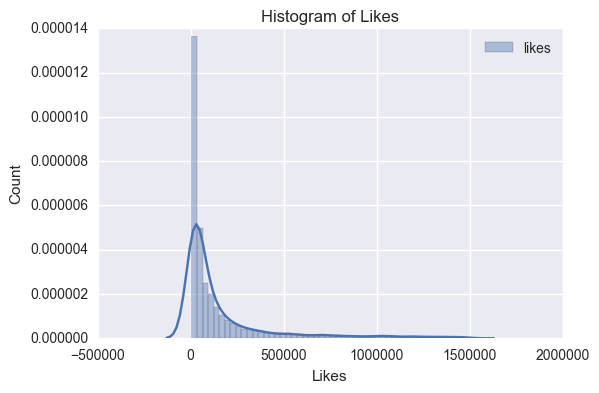

In [79]:
print all_data.likes.describe()
sns.distplot(all_data[(all_data['likes'] > 5000) & (all_data['likes'] < 1500000)].likes, 
             bins = 50, kde = True, label = "likes")
plt.title('Histogram of Likes')
plt.xlabel('Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()


In [80]:
# print all_data.fanCount.describe()
# sns.distplot(all_data[(all_data['fanCount'] > 100) & (all_data['fanCount'] < 50000)].fanCount, 
#              bins = 50, kde = True, label = "fanCount")
# plt.title('Histogram of fanCount')
# plt.xlabel('fanCount')
# plt.ylabel('Count')
# plt.legend(loc="upper right")
# plt.show()

count       12,794.00
mean        31,034.62
std        231,225.39
min              0.00
25%             96.00
50%            761.50
75%          5,229.50
max     17,288,994.00
Name: talking_about_count, dtype: float64


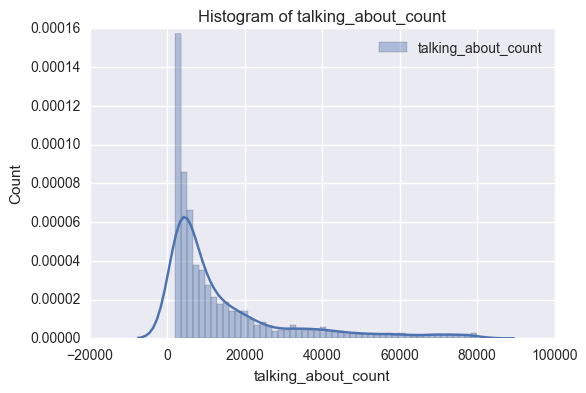

In [81]:
print all_data.talking_about_count.describe()
sns.distplot(all_data[(all_data['talking_about_count'] > 2000) & (all_data['talking_about_count'] < 80000)].talking_about_count, 
             bins = 50, kde = True, label = "talking_about_count")
plt.title('Histogram of talking_about_count')
plt.xlabel('talking_about_count')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

count       12,794.00
mean        22,770.80
std        283,162.81
min              0.00
25%              0.00
50%             30.00
75%            900.00
max     24,512,891.00
Name: were_here_count, dtype: float64


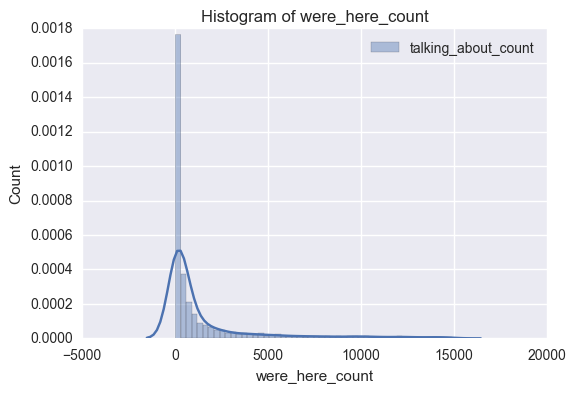

In [82]:
print all_data.were_here_count.describe()
sns.distplot(all_data[(all_data['were_here_count'] > 10) & (all_data['were_here_count'] < 15000)].were_here_count, 
             bins = 50, kde = True, label = "talking_about_count")
plt.title('Histogram of were_here_count')
plt.xlabel('were_here_count')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()


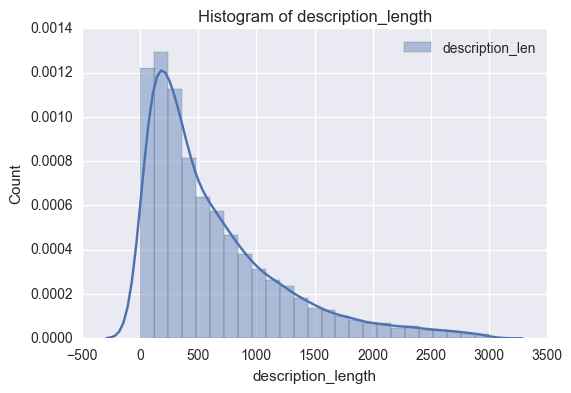

In [83]:
sns.distplot(all_data[(all_data['description_len'] > 0) & (all_data['description_len'] < 3000)].description_len, 
             bins = 25, kde = True, label = "description_len")
plt.title('Histogram of description_length')
plt.xlabel('description_length')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

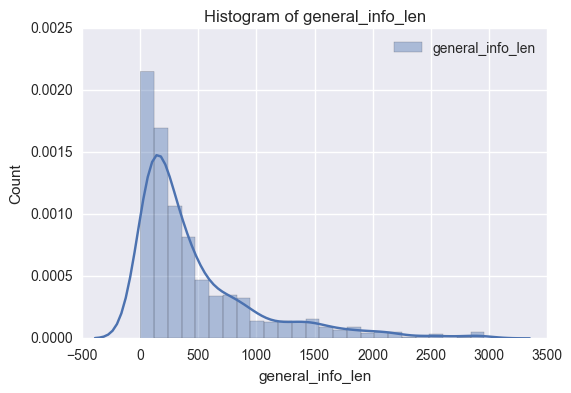

In [84]:
sns.distplot(all_data[(all_data['general_info_len'] > 0) & (all_data['general_info_len'] < 3000)].general_info_len, 
             bins = 25, kde = True, label = "general_info_len")
plt.title('Histogram of general_info_len')
plt.xlabel('general_info_len')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

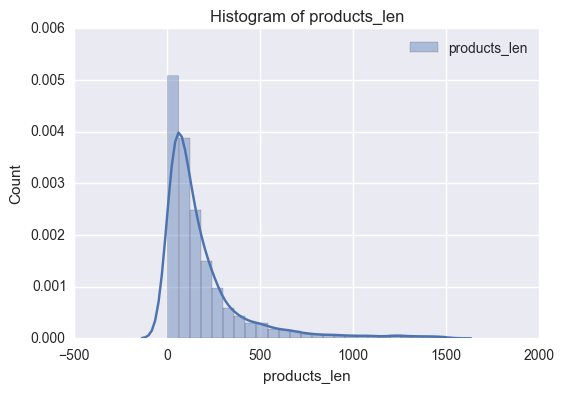

In [85]:
sns.distplot(all_data[(all_data['products_len'] > 0) & (all_data['products_len'] < 1500)].products_len, 
             bins = 25, kde = True, label = "products_len")
plt.title('Histogram of products_len')
plt.xlabel('products_len')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

### Categorical feature bars

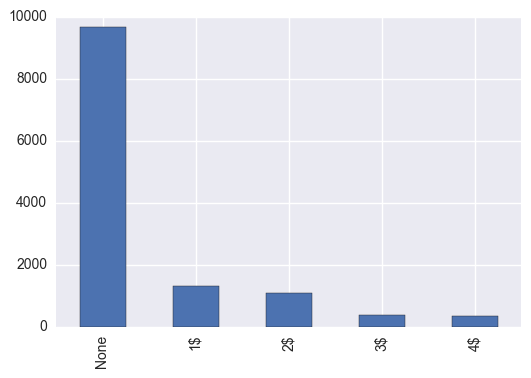

In [86]:
named_labels = all_data.price_range.map({0:'None', 1:'1$', 2:'2$', 3:'3$', 4:'4$'})
named_labels.value_counts().plot(kind='bar')

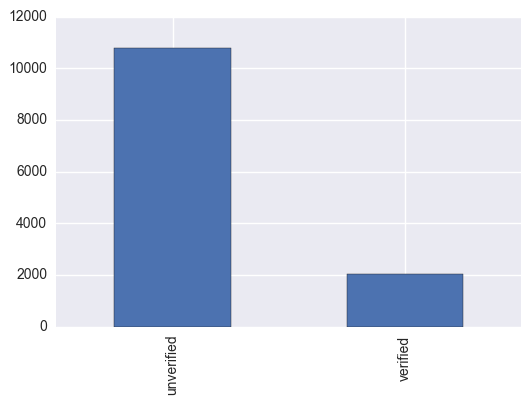

In [87]:
named_labels = all_data.is_verified.map({0:'unverified', 1:'verified'})
named_labels.value_counts().plot(kind='bar')

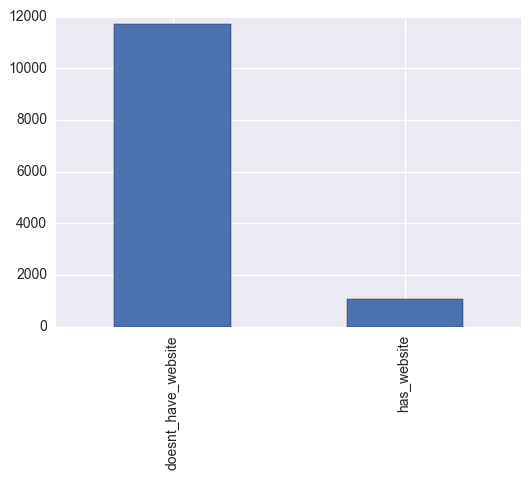

In [88]:
named_labels = all_data.has_website.map({0:'has_website', 1:'doesnt_have_website'})
named_labels.value_counts().plot(kind='bar')

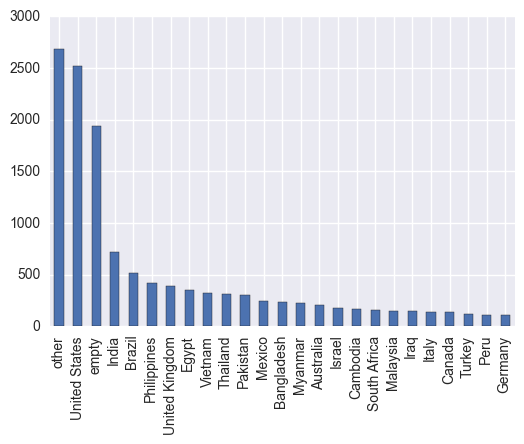

In [89]:
all_data['country'].value_counts().plot(kind='bar')

In [90]:
 all_data[all_data['is_permanently_closed'] == 1].shape[0]

5

In [91]:
 all_data[all_data['likes'] > 1500000].shape[0]

760

In [92]:
detail_variables = ['description_len', 'general_info_len', 'products_len']
all_data[detail_variables].corr()

,description_len,general_info_len,products_len
description_len,1.00,0.05,0.11
general_info_len,0.05,1.00,0.02
products_len,0.11,0.02,1.00


In [93]:
interaction_variables = ['likes', 'talking_about_count', 'were_here_count'] #'fanCount', 
all_data[interaction_variables].corr()

,likes,talking_about_count,were_here_count
likes,1.00,0.27,0.29
talking_about_count,0.27,1.00,0.01
were_here_count,0.29,0.01,1.00


In [94]:
all_data[['likes'] + detail_variables].corr()

,likes,description_len,general_info_len,products_len
likes,1.00,-0.00,-0.00,0.00
description_len,-0.00,1.00,0.05,0.11
general_info_len,-0.00,0.05,1.00,0.02
products_len,0.00,0.11,0.02,1.00


In [95]:
# TODO: add photo correlations

# photo_variables = ['total_photos', 'number_of_albums', 'number_of_normal_albums', 'number_of_wall_albums', 'number_of_mobile_albums',
#                    'number_of_cover_albums', 'number_of_profile_albums', 'number_of_app_albums', 'number_of_photos_in_normal_albums',
#                    'number_of_photos_in_wall_albums', 'number_of_photos_in_mobile_albums', 'number_of_photos_in_cover_albums', 'number_of_photos_in_profile_albums',
#                    'number_of_photos_in_app_albums', 'number_of_photos_with_tagged_people_without_self', 'number_of_different_photo_uploaders', 'number_of_photos_with_tagged_people_without_self', 'total_number_of_people_tagged_in_photos',
#                    'number_of_photos_self_tagged', 'avg_number_of_people_tagged_in_photos', 'number_of_different_months_for_photos']
# pp_data[photo_variables].corr()

In [96]:
# sns.set(color_codes=True)
# scatter = pd.DataFrame()
# sample = all_data[all_data['likes'] < 150000]
# scatter['likes'] = sample['likes']#.apply(lambda x: x/1000)
# scatter['fanCount'] = sample['fanCount']#.apply(lambda x: x/1000)
# rows = random.sample(scatter.index, 1000)
# scatter_10 = scatter.ix[rows]
# sns.regplot('likes', 'fanCount', scatter_10, 
#             scatter_kws={"marker": ".", "color": "green"},
#             line_kws = {"linewidth": "1", "color": "green"},
#             order = 2,
#             label = '<150K')
# plt.xlabel('Likes')
# plt.ylabel('fanCount')
# plt.legend(loc="lower right")
# plt.title("Scatter plot of Likes and fanCount")

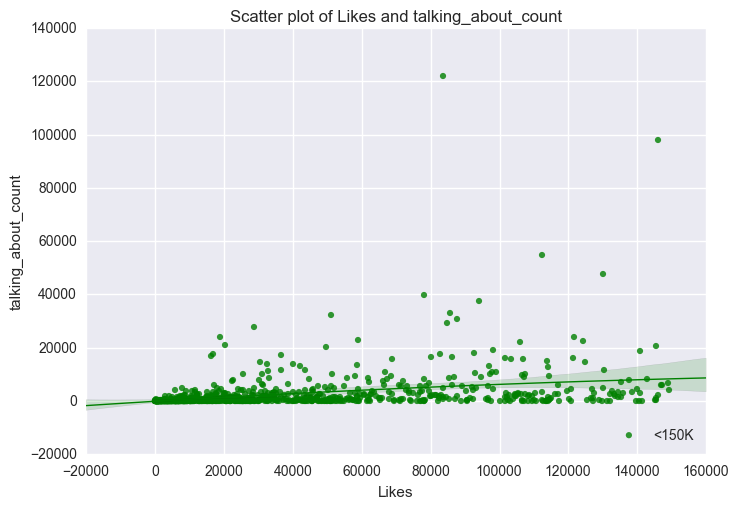

In [97]:
sns.set(color_codes=True)
scatter = pd.DataFrame()
sample = all_data[all_data['likes'] < 150000]
scatter['likes'] = sample['likes']#.apply(lambda x: x/1000)
scatter['talking_about_count'] = sample['talking_about_count']#.apply(lambda x: x/1000)
rows = random.sample(scatter.index, 1000)
scatter_10 = scatter.ix[rows]
sns.regplot('likes', 'talking_about_count', scatter_10, 
            scatter_kws={"marker": ".", "color": "green"},
            line_kws = {"linewidth": "1", "color": "green"},
            order = 2,
            label = '<150K')
plt.xlabel('Likes')
plt.ylabel('talking_about_count')
plt.legend(loc="lower right")
plt.title("Scatter plot of Likes and talking_about_count")

In [98]:
categorical_variables = ['country']

for variable in categorical_variables:
  print ("-------------------------------")
  print ("Histogram for " + variable)
  print ("-------------------------------")
  print (all_data[variable].value_counts())
  print ("")

-------------------------------
Histogram for country
-------------------------------
other             2687
United States     2517
empty             1934
India              715
Brazil             518
Philippines        421
United Kingdom     388
Egypt              353
Vietnam            318
Thailand           313
Pakistan           298
Mexico             248
Bangladesh         237
Myanmar            230
Australia          206
Israel             180
Cambodia           168
South Africa       154
Malaysia           149
Iraq               147
Italy              143
Canada             138
Turkey             115
Peru               109
Germany            108
Name: country, dtype: int64



#  Data cleaning

## Remove Outliers

In [99]:
filtered_all_data = all_data.copy()
filtered_all_data = filtered_all_data[filtered_all_data['is_permanently_closed'] != 1]
filtered_all_data = filtered_all_data[filtered_all_data.number_of_days_between_first_and_last_photos > 0]
filtered_all_data.drop('is_permanently_closed', axis = 1,  inplace=True)

filtered_all_data.head(5)

,has_cover_photo,has_profile_photo,id,likes,avg_comments_per_photo,avg_comments_total_likes,avg_distinct_comments_writers,avg_likes_per_photo,avg_people_tagged_per_photo,avg_people_tagged_per_photo_with_more_than_zero,...,has_location,description_len,general_info_len,name_len,products_len,name_num_of_words,photo_upload_freq,feed_update_freq,founded,country
0,1,1,109626372391961,13311,1.33,1.00,1.33,0.67,0.00,0.00,...,1,79.00,0.00,5,0.00,1,3,0,"1,995.00",Canada
1,1,1,834585939923334,16361,1.83,0.75,1.75,44.58,0.00,0.00,...,1,303.00,0.00,8,0.00,2,31,0,"1,995.00",other
2,1,1,10150149049510092,6947,1.45,0.75,1.40,12.75,1.20,1.85,...,1,199.00,0.00,6,25.00,1,2,0,"2,009.00",other
4,1,1,57843015021,227009,18.50,13.54,18.22,52.34,1.14,3.56,...,1,153.00,0.00,6,0.00,2,62,0,"1,995.00",United Kingdom
6,1,1,226269077569044,288531,13.37,12.75,13.11,76.37,0.01,1.00,...,1,0.00,0.00,14,0.00,2,14,0,"1,995.00",United States


In [100]:
feats_to_normalize = ['count_has_name', 'count_has_place', 'distinct_uploaders', 'number_of_albums', 'number_of_cover_albums', 
                      'number_of_different_months_for_photos', 
                      'number_of_null_albums', 'number_of_other_albums', 'number_of_photos_in_cover_albums', 
                      'number_of_photos_in_null_albums', 'number_of_photos_in_other_albums', 'number_of_photos_in_profile_albums',
                      'number_of_profile_albums', 'sum_comments_count', 'sum_like_count', 'sum_people_tagged_count', 'total_photos',
#                       'likes'
                 ]

# filtered_all_data[feats_to_normalize] = filtered_all_data[feats_to_normalize].div(filtered_all_data.number_of_days_between_first_and_last_photos, axis=0)
filtered_all_data[feats_to_normalize] = filtered_all_data[feats_to_normalize].apply(lambda x: (x - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) != 0 else 0)

filtered_all_data.head(5)

,has_cover_photo,has_profile_photo,id,likes,avg_comments_per_photo,avg_comments_total_likes,avg_distinct_comments_writers,avg_likes_per_photo,avg_people_tagged_per_photo,avg_people_tagged_per_photo_with_more_than_zero,...,has_location,description_len,general_info_len,name_len,products_len,name_num_of_words,photo_upload_freq,feed_update_freq,founded,country
0,1,1,109626372391961,13311,1.33,1.00,1.33,0.67,0.00,0.00,...,1,79.00,0.00,5,0.00,1,3,0,"1,995.00",Canada
1,1,1,834585939923334,16361,1.83,0.75,1.75,44.58,0.00,0.00,...,1,303.00,0.00,8,0.00,2,31,0,"1,995.00",other
2,1,1,10150149049510092,6947,1.45,0.75,1.40,12.75,1.20,1.85,...,1,199.00,0.00,6,25.00,1,2,0,"2,009.00",other
4,1,1,57843015021,227009,18.50,13.54,18.22,52.34,1.14,3.56,...,1,153.00,0.00,6,0.00,2,62,0,"1,995.00",United Kingdom
6,1,1,226269077569044,288531,13.37,12.75,13.11,76.37,0.01,1.00,...,1,0.00,0.00,14,0.00,2,14,0,"1,995.00",United States


# Models

## Preprocessing

### dummies variables 

In [101]:
# change back empty and 0 to NaN before converting to dummy variables
country_dv = pd.get_dummies(filtered_all_data['country'].apply(lambda x: x if x != 'empty' else np.nan), prefix='country')
price_dv = pd.get_dummies(filtered_all_data['price_range'].apply(lambda x: x if x > 0 else np.nan), prefix='price_range')

pp_data = pd.concat([filtered_all_data, country_dv, price_dv], axis=1)
pp_data.drop(categorical_variables, 1, inplace=True)
pp_data.dtypes

has_cover_photo                                      int64
has_profile_photo                                    int64
id                                                   int64
likes                                                int64
avg_comments_per_photo                             float64
avg_comments_total_likes                           float64
avg_distinct_comments_writers                      float64
avg_likes_per_photo                                float64
avg_people_tagged_per_photo                        float64
avg_people_tagged_per_photo_with_more_than_zero    float64
count_has_name                                     float64
count_has_place                                    float64
distinct_uploaders                                   int64
number_of_albums                                   float64
number_of_cover_albums                             float64
number_of_days_between_first_and_last_photos         int64
number_of_different_months_for_photos              float

In [102]:
pp_data.head(5)

,has_cover_photo,has_profile_photo,id,likes,avg_comments_per_photo,avg_comments_total_likes,avg_distinct_comments_writers,avg_likes_per_photo,avg_people_tagged_per_photo,avg_people_tagged_per_photo_with_more_than_zero,...,country_Thailand,country_Turkey,country_United Kingdom,country_United States,country_Vietnam,country_other,price_range_1.0,price_range_2.0,price_range_3.0,price_range_4.0
0,1,1,109626372391961,13311,1.33,1.00,1.33,0.67,0.00,0.00,...,0,0,0,0,0,0,0,1,0,0
1,1,1,834585939923334,16361,1.83,0.75,1.75,44.58,0.00,0.00,...,0,0,0,0,0,1,0,0,0,0
2,1,1,10150149049510092,6947,1.45,0.75,1.40,12.75,1.20,1.85,...,0,0,0,0,0,1,0,0,0,0
4,1,1,57843015021,227009,18.50,13.54,18.22,52.34,1.14,3.56,...,0,0,1,0,0,0,0,0,0,0
6,1,1,226269077569044,288531,13.37,12.75,13.11,76.37,0.01,1.00,...,0,0,0,1,0,0,0,0,0,0


### split to test and train

In [103]:
train_set, test_set = train_test_split(pp_data, test_size = 0.2)
print len(train_set), len(test_set)

9786 2447


## Utils

In [104]:
def binning(col,bin_num, labels=None):
    if labels is None:
        labels = ['BIN_'+str(i) for i in range(bin_num)]

    colBin = pd.qcut(col,bin_num,labels=labels)
# TODO - rename bins by min-max vals
#     df = DataFrame()
#     df['col'] = col
#     df['bins'] = colBin
#     grouped = df['col'].groupby('bins')
    
    return colBin

def plot_results(x, y, tag, arg):
    plt.plot(x, y)
    plt.title(tag + " as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel(tag)
    plt.show()

def plot_cross_val(cs, cv_scores, arg):
    plt.plot(cs, cv_scores)
    plt.title("Average Precision as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel("Precision")
    ax = plt.axes()
    ax.set_xscale('log')
    plt.show()

def plotRoc(fpr, tpr, auc):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def plotPR(precision, recall):
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve')
    plt.legend(loc='lower left')
    plt.show()

def plotMetrics(expected,predicted):
    y_true = expected
    y_score = predicted
    #y_score = df['rawPrediction'].map(lambda x: x['values'][1])
    auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    plotRoc(fpr, tpr, auc)
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
    plotPR(precision, recall)

def plotConfusion(matrix, n):
    plt.title('Confusion Matrix Image')
    plt.imshow(np.reshape(matrix, (n, n)), interpolation='nearest', cmap="hot")
    plt.colorbar()
    plt.show()

### Convert likes count to bins and print bin details

In [105]:
train_len = int(len(pp_data['id']) * 0.8)
bin_num = 4
pp_data['labels'] = binning(pp_data['likes'], bin_num)

bin_data = pp_data.groupby('labels')['likes'].describe()
print bin_data
bin_names = ['BIN_0', 'BIN_1', 'BIN_2'] 
seperators = [bin_data[bin_name]['max'] for bin_name in bin_names]

labels       
BIN_0   count         3,059.00
        mean          4,152.26
        std           2,966.68
        min               0.00
        25%           1,430.50
        50%           3,643.00
        75%           6,587.00
        max          10,158.00
BIN_1   count         3,058.00
        mean         22,439.35
        std           8,670.62
        min          10,169.00
        25%          14,784.25
        50%          21,231.50
        75%          29,279.50
        max          40,747.00
BIN_2   count         3,058.00
        mean         90,189.24
        std          38,642.12
        min          40,768.00
        25%          56,085.50
        50%          80,891.00
        75%         118,732.75
        max         178,859.00
BIN_3   count         3,058.00
        mean      1,551,841.47
        std       4,008,153.11
        min         179,143.00
        25%         301,382.00
        50%         609,037.50
        75%       1,459,768.25
        max     102,762,5

## Logistic Regression

C=1e-10: 0.961314585026
C=1.38949549437e-09: 0.965005973193
C=1.93069772888e-08: 0.965766386859
C=2.68269579528e-07: 0.96772853774
C=3.72759372031e-06: 0.968997638286
C=5.17947467923e-05: 0.969020111761
C=0.000719685673001: 0.968906583596
C=0.01: 0.968912139027


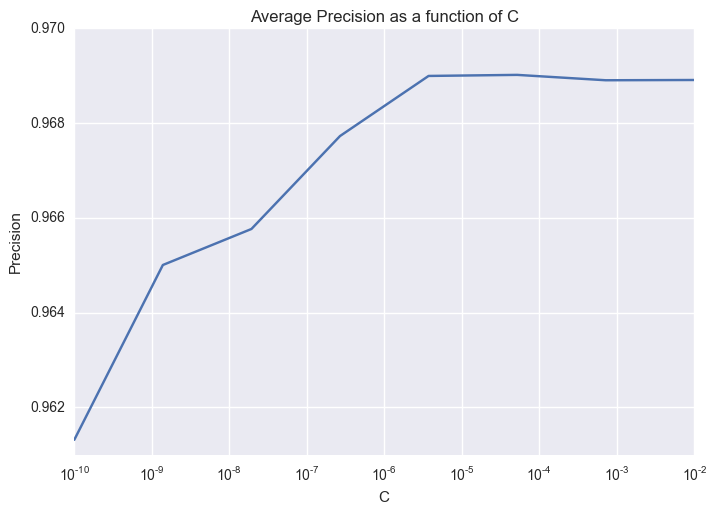

training logistic regression BIN_0
getting logistic regression predictions BIN_0
calculating logistic regression Performance on the train set: BIN_0
logistic regression train set auc: 0.904810434818


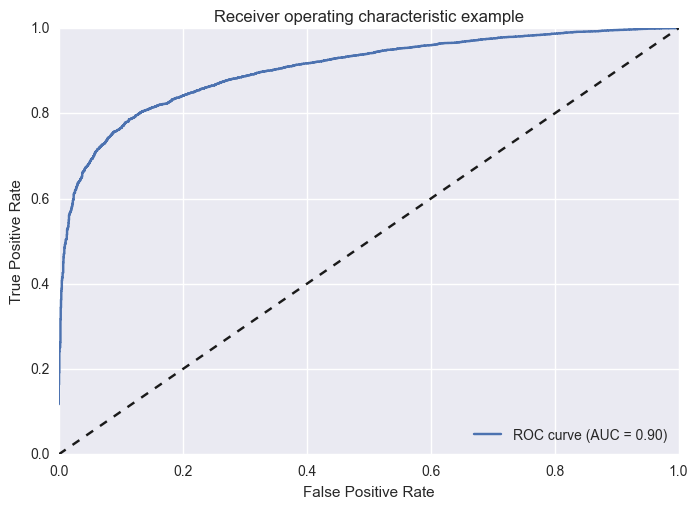

calculating logistic regression Performance on the test set: BIN_0
             precision    recall  f1-score   support

          0       0.78      0.65      0.71       810
          1       0.84      0.91      0.87      1637

avg / total       0.82      0.82      0.82      2447



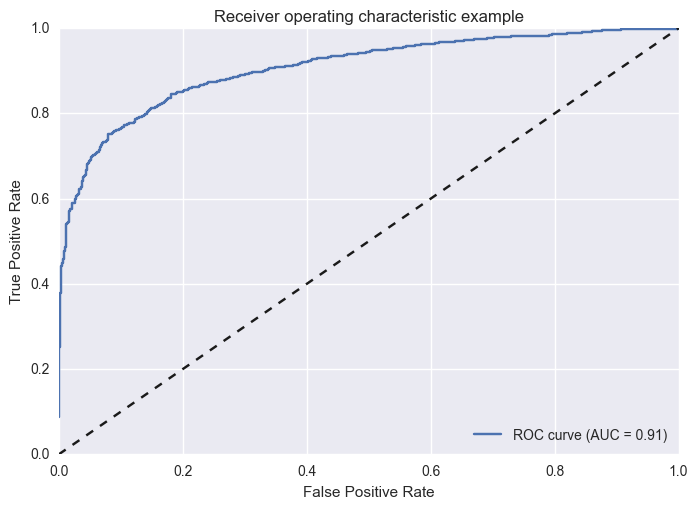

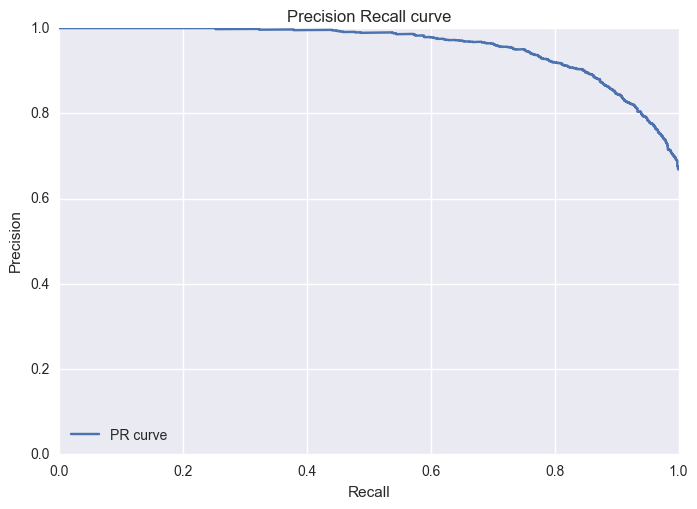

C=1e-10: 0.886192974219
C=1.38949549437e-09: 0.893821441467
C=1.93069772888e-08: 0.893986619261
C=2.68269579528e-07: 0.902057476041
C=3.72759372031e-06: 0.908377193864
C=5.17947467923e-05: 0.909762780586
C=0.000719685673001: 0.909921056998
C=0.01: 0.909553534005


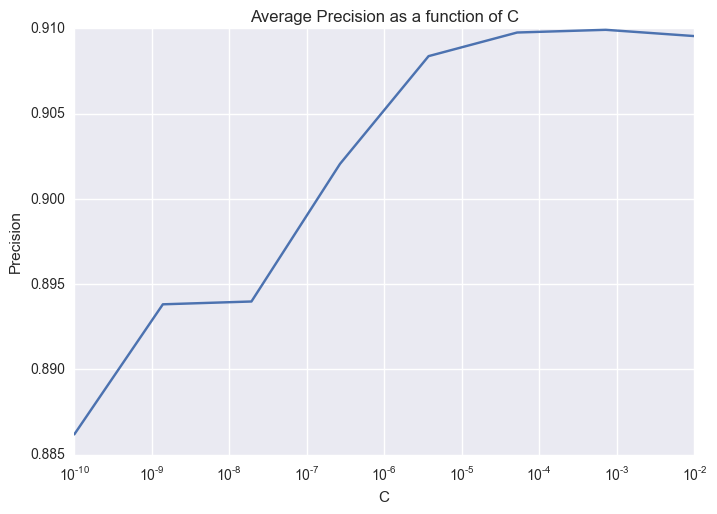

training logistic regression BIN_1
getting logistic regression predictions BIN_1
calculating logistic regression Performance on the train set: BIN_1
logistic regression train set auc: 0.895287298471


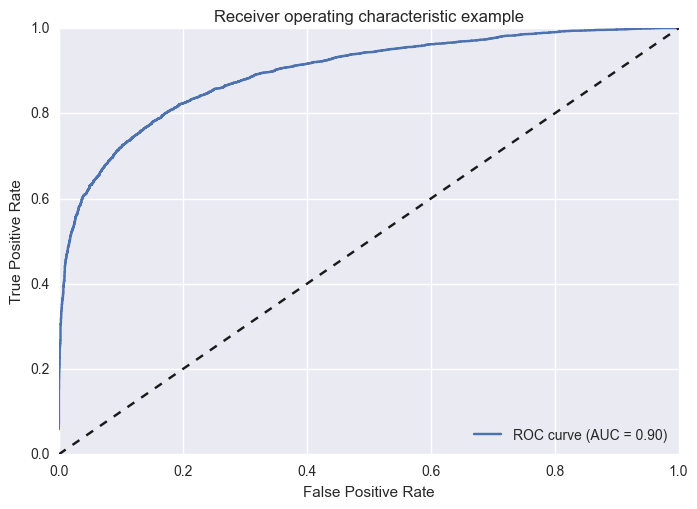

calculating logistic regression Performance on the test set: BIN_1
             precision    recall  f1-score   support

          0       0.84      0.87      0.86      1389
          1       0.82      0.79      0.80      1058

avg / total       0.83      0.83      0.83      2447



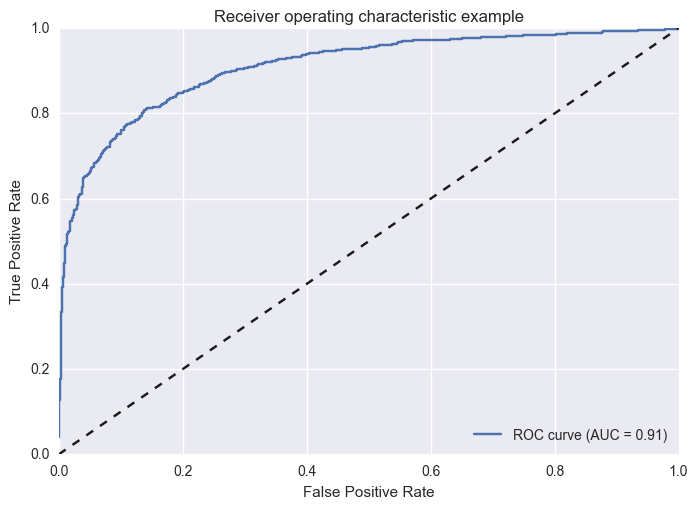

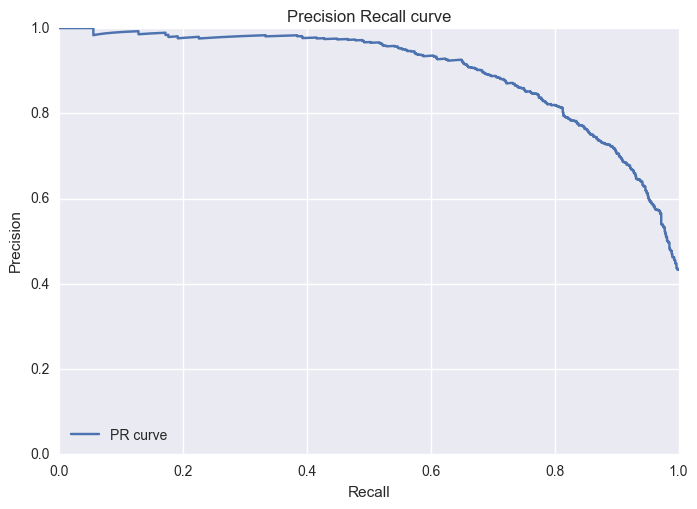

C=1e-10: 0.738775981644
C=1.38949549437e-09: 0.820185596058
C=1.93069772888e-08: 0.81755310882
C=2.68269579528e-07: 0.825412894002
C=3.72759372031e-06: 0.836090237157
C=5.17947467923e-05: 0.833568727274
C=0.000719685673001: 0.837273164379
C=0.01: 0.834250305304


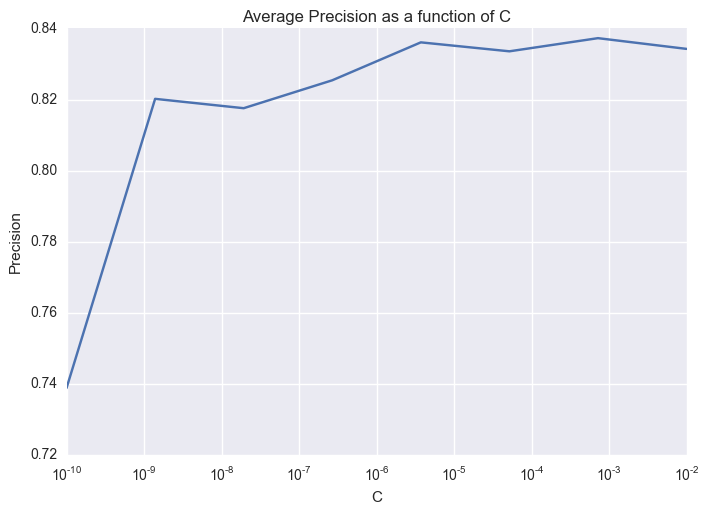

training logistic regression BIN_2
getting logistic regression predictions BIN_2
calculating logistic regression Performance on the train set: BIN_2
logistic regression train set auc: 0.918675415823


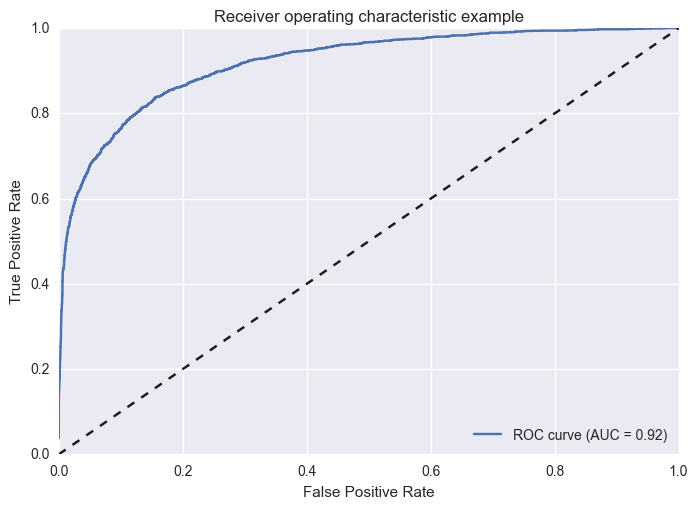

calculating logistic regression Performance on the test set: BIN_2
             precision    recall  f1-score   support

          0       0.88      0.97      0.93      1888
          1       0.86      0.57      0.68       559

avg / total       0.88      0.88      0.87      2447



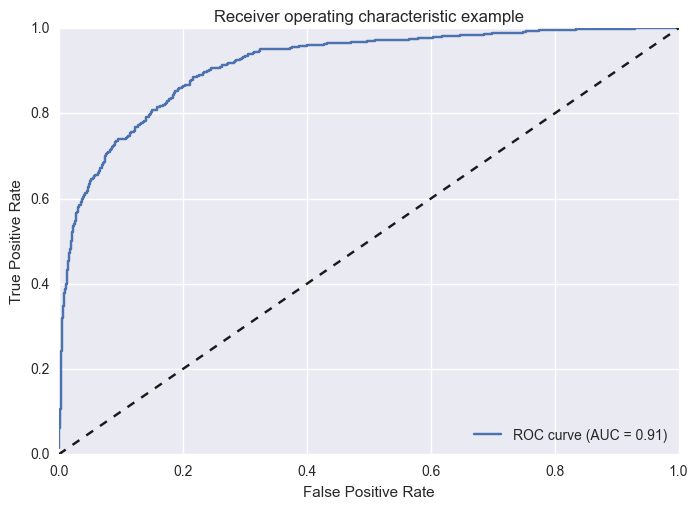

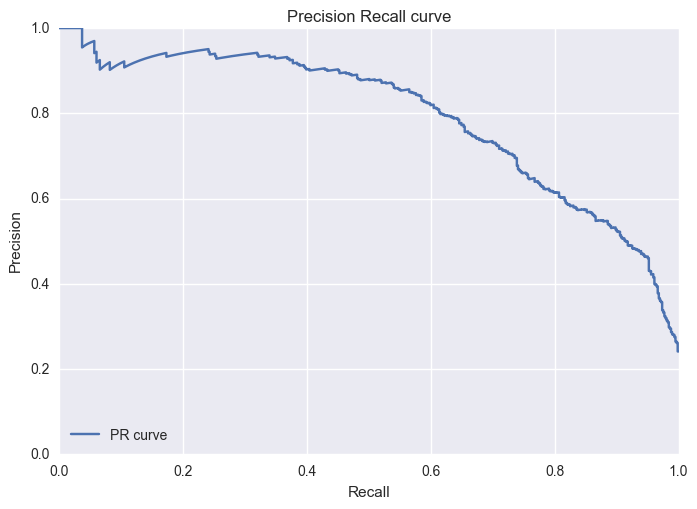

In [106]:
for seperator in seperators:
    lr_train_len = train_len
    lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= seperator else 1)
    lr_ids = pp_data['id']

    lr_train_set = pp_data[:lr_train_len].copy()
    lr_test_set = pp_data[lr_train_len:].copy()

    lr_train_labels = lr_labels[:lr_train_len].copy()
    lr_test_labels = lr_labels[lr_train_len:].copy()

    lr_train_ids = lr_ids[:lr_train_len].copy()
    lr_test_ids = lr_ids[lr_train_len:].copy()

    lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    lr_set = lr_train_set.append(lr_test_set, ignore_index=True)
    
    cv_scores = []
    space = np.logspace(-10,-2, num=8)
    for c in space:
        res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
        print "C=%s: %s" % (c, np.average(res))
        cv_scores.append(np.average(res))

    plot_cross_val(space, cv_scores, "C")
    lr_selceted_c = space[cv_scores.index(max(cv_scores))]
    
    print "training logistic regression", bin_names[seperators.index(seperator)]
    lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)

    lr.fit(lr_train_set, lr_train_labels)
    print "getting logistic regression predictions", bin_names[seperators.index(seperator)]
    lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
    lr_predictions = lr.predict(lr_set)

    lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
    lr_test_predicted_probs = lr_predicted_probs[lr_train_len:]

    lr_train_predictions = lr_predictions[:lr_train_len]
    lr_test_predictions = lr_predictions[lr_train_len:]

    # attach LR predictions to the data as another feature
    pp_data['lr_prediction_%s' % bin_names[seperators.index(seperator)]] = lr_predictions.copy()
    pp_data['lr_prediction_proba_%s' % bin_names[seperators.index(seperator)]] = lr_predicted_probs.copy()

    print "calculating logistic regression Performance on the train set:", bin_names[seperators.index(seperator)]
    fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
    lr_auc = metrics.auc(fpr, tpr)
    print "logistic regression train set auc:", lr_auc
    plotRoc(fpr, tpr, lr_auc)
    print "calculating logistic regression Performance on the test set:", bin_names[seperators.index(seperator)]
    print(metrics.classification_report(lr_test_labels, lr_test_predictions))
    plotMetrics(lr_test_labels,lr_test_predicted_probs)


 Deciding bin placements by logistic regressions binary predictions..
Got bin placements, 1 values determined by higher probability, 1 by probability sum, 12275 were definitive


ALL DATA:
[[1606 1293  165    6]
 [ 564 1703  770   32]
 [ 159 1038 1549  323]
 [  23  196  975 1875]]


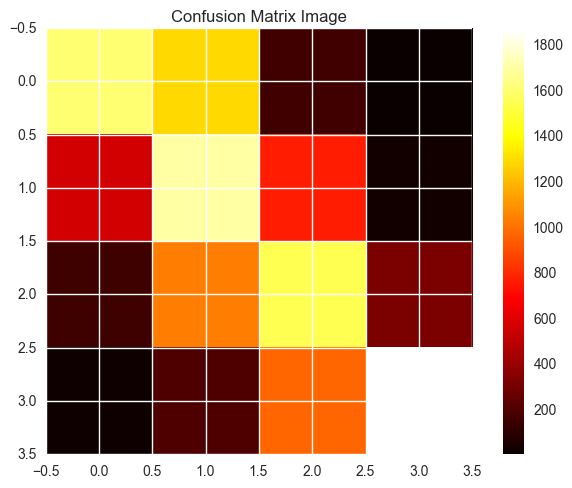

TEST SET ONLY:
[[465 303  47   1]
 [120 313 137  10]
 [ 25 161 257  58]
 [  9  42 191 317]]


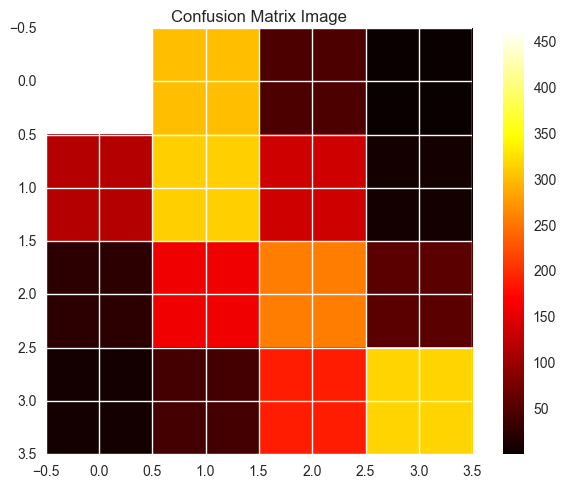

train score: 0.591271178905
train score: 0.547907545057
test score: 0.590318526693
test score: 0.550488599349


In [63]:
# unify predictions for bin classification
undef_1 = 0
undef_2 = 0

def decide_bin(row):
    global undef_1, undef_2
    preds = (row['lr_prediction_BIN_0'], row['lr_prediction_BIN_1'], row['lr_prediction_BIN_2'])
    pred_probas = (row['lr_prediction_proba_BIN_0'], row['lr_prediction_proba_BIN_1'], row['lr_prediction_proba_BIN_2'])

    if preds == (0, 0, 0):
        return 'BIN_0'
    elif preds == (1, 0, 0):
        return 'BIN_1'
    elif preds == (1, 1, 0):
        return 'BIN_2'
    elif preds == (1, 1, 1):
        return 'BIN_3'
    
    undef_1 += 1
    if preds[0] == 0 and pred_probas[0] < (1 - pred_probas[1]) and pred_probas[0] < (1 - pred_probas[2]):
        return 'BIN_0'

    if preds[2] == 1 and pred_probas[2] > (1 - pred_probas[1]) and pred_probas[2] > (1 - pred_probas[0]):
        return 'BIN_3'
    
    undef_2 += 1
    return 'BIN_%s' % int(round(sum(pred_probas)))

print "Deciding bin placements by logistic regressions binary predictions.."
bin_predictions = pp_data.apply(decide_bin, axis=1)
print "Got bin placements, %s values determined by higher probability, %s by probability sum, %s were definitive\n\n" % (undef_1, undef_2, pp_data.id.count() - undef_1 - undef_2)

print "========="
print "ALL DATA:"
print "========="
m = confusion_matrix(pp_data['labels'].values, bin_predictions.values)
print m
plotConfusion(m, 4)

print "=============="
print "TEST SET ONLY:"
print "=============="
m = confusion_matrix(pp_data['labels'][lr_train_len:].values, bin_predictions[lr_train_len:].values)
print m
plotConfusion(m, 4)

print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='macro')
print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='micro')
# print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='samples')
print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='macro')
print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='micro')
# print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='samples')

In [37]:

lr_train_len = train_len
# lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= seperator else 1)
lr_labels = pp_data['labels'].apply(lambda x: int(x[-1]))
lr_ids = pp_data['id']

lr_train_set = pp_data[:lr_train_len].copy()
lr_test_set = pp_data[lr_train_len:].copy()

lr_train_labels = lr_labels[:lr_train_len].copy()
lr_test_labels = lr_labels[lr_train_len:].copy()

lr_train_ids = lr_ids[:lr_train_len].copy()
lr_test_ids = lr_ids[lr_train_len:].copy()

lr_train_set.drop(['likes', 'id', 'labels', 'lr_prediction'], 1, inplace=True)
lr_test_set.drop(['likes', 'id', 'labels', 'lr_prediction'], 1, inplace=True)
lr_set = lr_train_set.append(lr_test_set, ignore_index=True)

# cv_scores = []
# space = np.logspace(-10,-2, num=8)
# for c in space:
#     res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c, multi_class='ovr'), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
#     print "C=%s: %s" % (c, np.average(res))
#     cv_scores.append(np.average(res))

# plot_cross_val(space, cv_scores, "C")
# lr_selceted_c = space[cv_scores.index(max(cv_scores))]

print "training logistic regression - multi class"
lr = lm.LogisticRegression(penalty='l2', multi_class='ovr')  #penalty='l2' #dual=True) #lr_selceted_c)

lr.fit(lr_train_set, lr_train_labels)
print "getting logistic regression predictions - multi class"
# lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
lr_predictions = lr.predict(lr_set)

# lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
# lr_test_predicted_probs = lr_predicted_probs[lr_train_len:]

lr_train_predictions = lr.predict(lr_train_set)
lr_test_predictions = lr.predict(lr_test_set)

# attach LR predictions to the data as another feature
pp_data['lr_prediction'] = lr.predict(lr_set)

print "calculating logistic regression Performance on the train set - multi class:"
print lr.score(lr_train_set, lr_train_labels)
print lr.score(lr_test_set, lr_test_labels)

fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
lr_auc = metrics.auc(fpr, tpr)
print "logistic regression train set auc:", lr_auc
plotRoc(fpr, tpr, lr_auc)
print "calculating logistic regression Performance on the test set - multi class:"
print(metrics.classification_report(lr_test_labels, lr_test_predictions))
plotMetrics(lr_test_labels,lr_test_predicted_probs)


training logistic regression - multi class
getting logistic regression predictions - multi class
calculating logistic regression Performance on the train set - multi class:
0.553304144181
0.559853420195


ValueError: Data is not binary and pos_label is not specified

### Preprocessing

In [36]:
# lr_labelsfrom sklearn.metrics import confusion_matrixfrom sklearn.metrics import confusion_matrix = pp_data['likes']
lr_train_len = train_len
lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= seperator else 1)
lr_ids = pp_data['id']

lr_train_set = pp_data[:lr_train_len].copy()
lr_test_set = pp_data[lr_train_len:].copy()

lr_train_labels = lr_labels[:lr_train_len].copy()
lr_test_labels = lr_labels[lr_train_len:].copy()

lr_train_ids = lr_ids[:lr_train_len].copy()
lr_test_ids = lr_ids[lr_train_len:].copy()

lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_set = lr_train_set.append(lr_test_set, ignore_index=True)

### Parameter optimization

C=1e-12: 0.866633983332
C=1e-11: 0.879851560951
C=1e-10: 0.883927165336
C=1e-09: 0.890033280944
C=1e-08: 0.888102944427
C=1e-07: 0.893298975005
C=1e-06: 0.902186580893
C=1e-05: 0.904886141368


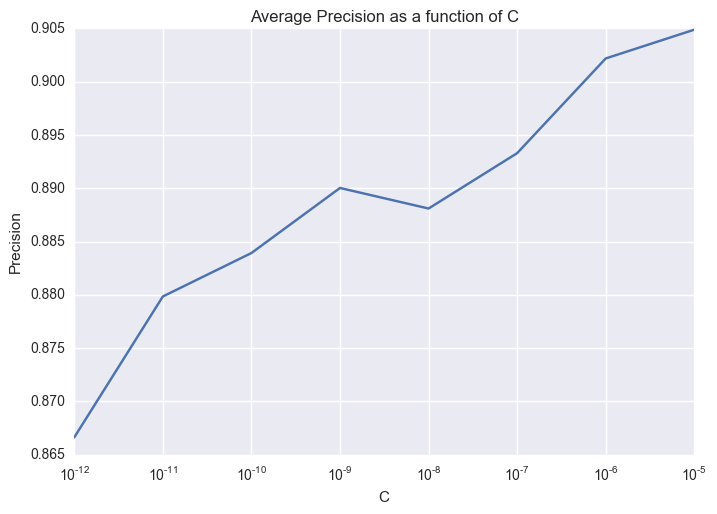

In [37]:
cv_scores = []
space = np.logspace(-10,-2, num=8)
for c in space:
    res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (c, np.average(res))
    cv_scores.append(np.average(res))

plot_cross_val(space, cv_scores, "C")
lr_selceted_c = space[cv_scores.index(max(cv_scores))]

C=1e-10: 0.883927165336
C=2.15443469003e-10: 0.887292982014
C=4.64158883361e-10: 0.889880287287
C=1e-09: 0.890033280944
C=2.15443469003e-09: 0.889221849537
C=4.64158883361e-09: 0.888324973356
C=1e-08: 0.888102944265


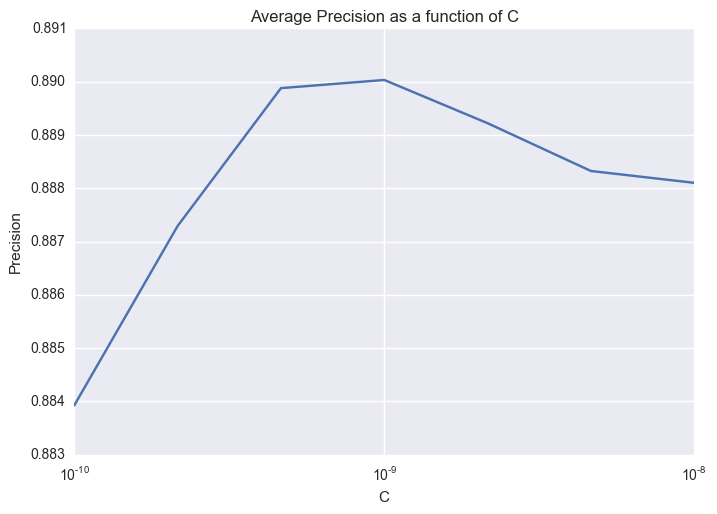

In [38]:
cv_scores = []
space = np.logspace(-10,-8, num=7)
for c in space:
    res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (c, np.average(res))
    cv_scores.append(np.average(res))

plot_cross_val(space, cv_scores, "C")
lr_selceted_c = space[cv_scores.index(max(cv_scores))]

### LR running 

training logistic regression
getting logistic regression predictions
calculating logistic regression Performance on the train set:
logistic regression train set auc: 0.865343621882


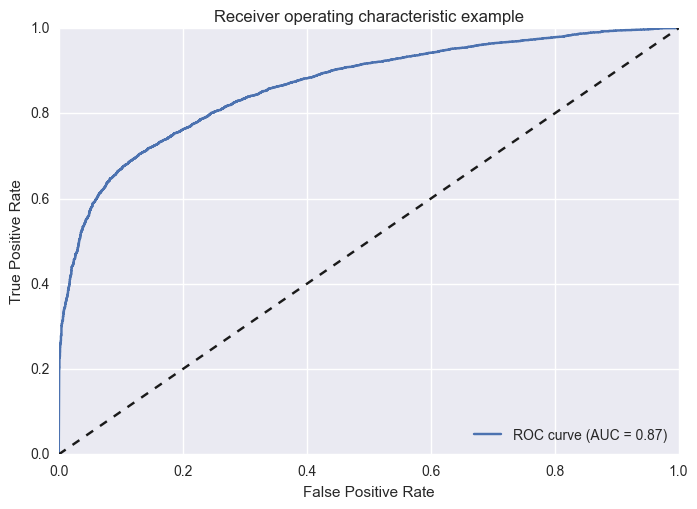

calculating logistic regression Performance on the test set:
             precision    recall  f1-score   support

          0       0.78      0.92      0.84      1506
          1       0.84      0.63      0.72      1059

avg / total       0.81      0.80      0.79      2565



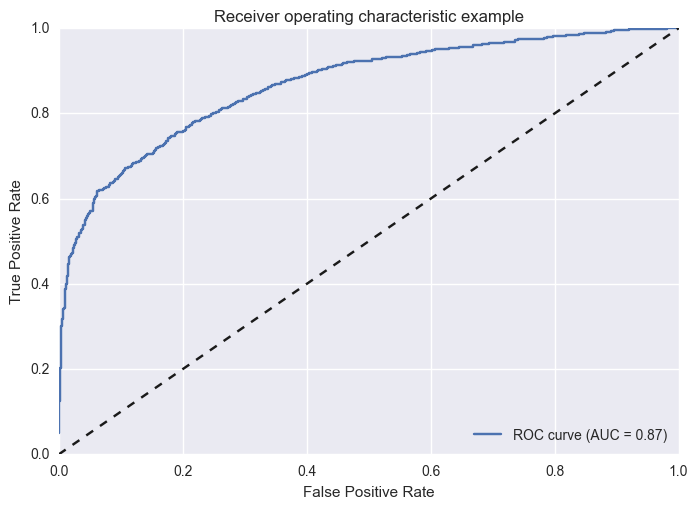

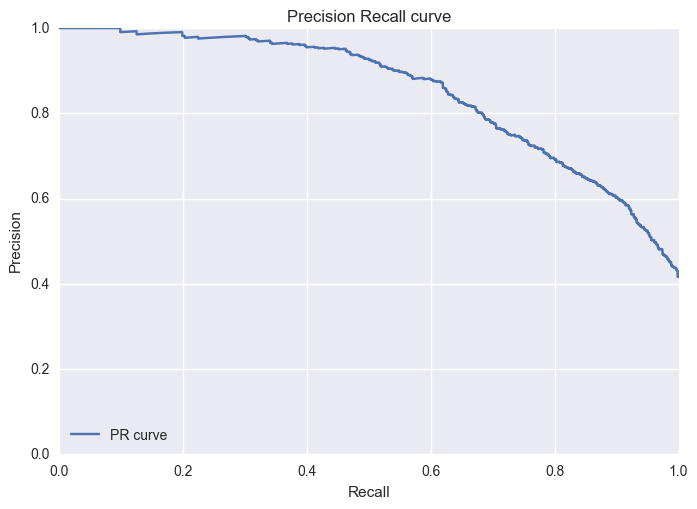

In [39]:
print "training logistic regression"
lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)

lr.fit(lr_train_set, lr_train_labels)
print "getting logistic regression predictions"
lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
lr_predictions = lr.predict(lr_set)

lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
lr_test_predicted_probs = lr_predicted_probs[lr_train_len:]

lr_train_predictions = lr_predictions[:lr_train_len]
lr_test_predictions = lr_predictions[lr_train_len:]

# attach LR predictions to the data as another feature
pp_data['lr_prediction'] = lr_predictions.copy()

print "calculating logistic regression Performance on the train set:"
fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
lr_auc = metrics.auc(fpr, tpr)
print "logistic regression train set auc:", lr_auc
plotRoc(fpr, tpr, lr_auc)
print "calculating logistic regression Performance on the test set:"
print(metrics.classification_report(lr_test_labels, lr_test_predictions))
plotMetrics(lr_test_labels,lr_test_predicted_probs)

# pected = test_class.values
# oh_test_data= oh_test.drop('class',axis=1)
# predicted = logreg.predict(oh_test_data)
# predicted_probs = logreg.predict_proba(oh_test_data)

#add LR score as a new feature
# train_set['logistic_regression_prediction'] = lr_train_predictions
# test_set['logistic_regression_prediction'] = lr_test_predictions

## SVM

### Preprocessing

In [40]:
svm_pp_data = pp_data.copy()
svm_train_len = train_len
svm_test_len = int(len(pp_data['id'])) - train_len
# svm_pp_data.drop(categorical_variables, 1, inplace=True)

svm_labels = svm_pp_data['likes'].apply(lambda x: 0 if x < seperator else 1)
svm_ids = svm_pp_data['id']

svm_train_set = svm_pp_data[:svm_train_len].copy()
svm_test_set = svm_pp_data[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_labels = svm_labels[:svm_train_len].copy()
svm_test_labels = svm_labels[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_ids = svm_ids[:svm_train_len].copy()
svm_test_ids = svm_ids[svm_train_len:svm_train_len+svm_test_len].copy()

svm_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
svm_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
svm_set = svm_train_set.append(svm_test_set, ignore_index=True)

### Parameter optimization 

C=1e-05: 0.527208519529
C=0.0001: 0.530358758403
C=0.001: 0.532842925863
C=0.01: 0.534132758145
C=0.1: 0.535914847971
C=1: 0.543450087451
C=10: 0.543853211037
C=100: 0.543853211037


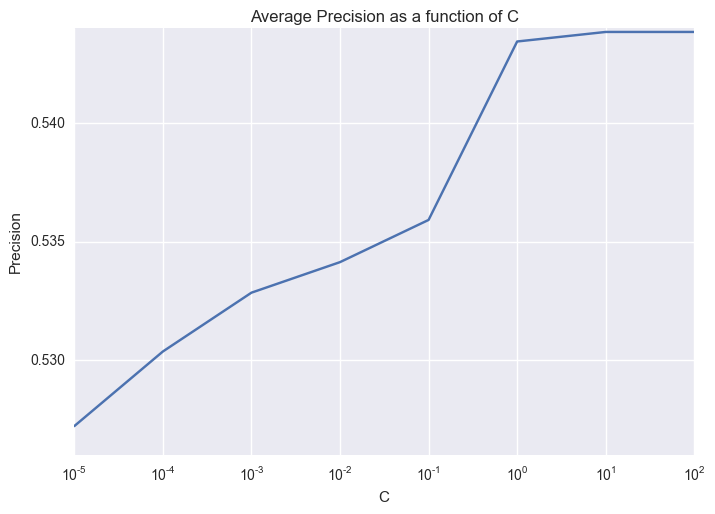

In [42]:
cv_scores = []
cs = []
for c in range(-5,3):#-2,2):
    res = cross_val_score(svm.SVC(C=10**c), svm_train_set, svm_train_labels, cv=3, scoring='roc_auc')
    print "C=%s: %s" % (10**c, np.average(res))
    cs.append(10**c)
    cv_scores.append(np.average(res))
    
plot_cross_val(cs, cv_scores, "C")
svm_selceted_c = cv_scores[cv_scores.index(max(cv_scores))]

### SVM run

In [518]:
# svm_selceted_c = 16.681005372
# svm_selceted_gamma = 0.0316227766017

svm_model = svm.SVC(probability=True, C=svm_selceted_c)#, gamma=svm_selceted_gamma)
svm_model.fit(pp_train_set, pp_train_labels)
svm_train_prediction = svm_model.predict_proba(pp_train_set)
svm_test_prediction = svm_model.predict_proba(pp_test_set)

fpr, tpr, thresholds = metrics.roc_curve(pp_train_labels, svm_train_prediction[:,1])
svm_train_auc = metrics.auc(fpr, tpr)
print "svm train set auc:", svm_train_auc

plotRoc(fpr, tpr, svm_train_auc)

(6689, 191)

## Random Forest

### Preprocessing

In [135]:
rf_train_len = train_len
rf_labels = pp_data['labels']
rf_ids = pp_data['id']

rf_train_set = pp_data[:rf_train_len].copy()
rf_test_set = pp_data[rf_train_len:].copy()


rf_train_ids = rf_ids[:rf_train_len].copy()
rf_test_ids = rf_ids[rf_train_len:].copy()

rf_train_labels = rf_labels[:rf_train_len].copy()
rf_test_labels = rf_labels[rf_train_len:].copy()

rf_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
rf_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)



### Parameter optimization

Feature ranking - Top 10:
1. feature 33 (talking_about_count)
   score: 0.129356
2. feature 77 (lr_prediction)
   score: 0.053623
3. feature 5 (avg_likes_per_photo)
   score: 0.052433
4. feature 26 (sum_like_count)
   score: 0.047529
5. feature 25 (sum_comments_count)
   score: 0.043339
6. feature 2 (avg_comments_per_photo)
   score: 0.039178
7. feature 20 (number_of_photos_in_profile_albums)
   score: 0.037609
8. feature 4 (avg_distinct_comments_writers)
   score: 0.036604
9. feature 13 (number_of_days_between_first_and_last_photos)
   score: 0.035812
10. feature 3 (avg_comments_total_likes)
   score: 0.031843


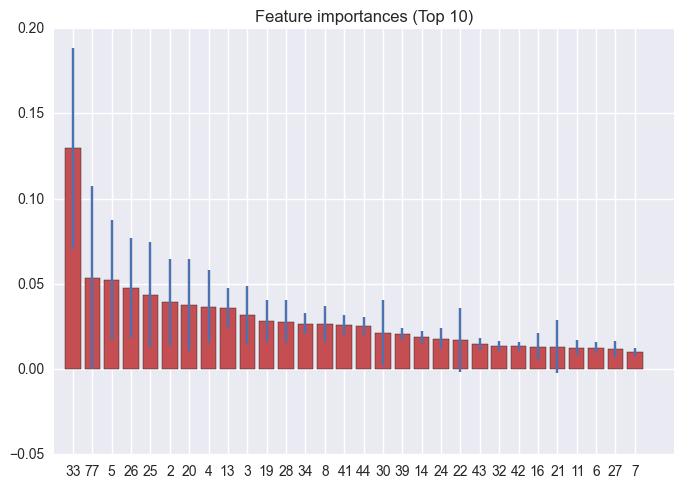

In [136]:
forest = RandomForestClassifier(n_estimators=250, max_depth=15)
forest.fit(rf_train_set.values, rf_train_labels.values)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking - Top 10:")
for f in range(10):
    print("%d. feature %d (%s)\n   score: %f" % (f + 1, indices[f], list(rf_train_set)[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plot_idxs = indices[:30]
plt.figure()
plt.title("Feature importances (Top 10)")
plt.bar(range(30), importances[plot_idxs],
       color="r", yerr=std[plot_idxs], align="center")
plt.xticks(range(30), plot_idxs)
plt.xlim([-1, 31])
plt.show()

In [137]:
importances_thresholds = [0, 0.01] #[0, 0.01, 0.02, 0.03, 0.04]
max_depths = [15, None] #[10, 20, 30, None]
min_samples_leaf = [1] #[1, 3, 5]

filtered_by_thresholds = []
for t in importances_thresholds:
    columns = []
    for f in range(rf_train_set.shape[1]):
        if importances[indices[f]] >= t:
            columns.append(list(rf_train_set)[indices[f]])
    filtered_by_thresholds.append(columns)

params = []
score_summary = []
print "(threshold, depth, min_samples) -> average precision score"
for i in range(len(filtered_by_thresholds)):
    for d in max_depths:
        for l in min_samples_leaf:
            cols = filtered_by_thresholds[i]
            forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=d, min_samples_leaf=l)
            forest.fit(rf_train_set, rf_train_labels)
            temp_predictions = forest.predict(rf_test_set)
            res = metrics.precision_score(rf_test_labels, temp_predictions, average='macro')
            score_summary.append(res)
            params.append((importances_thresholds[i], d, l))
            print "%s -> %s" % (params[-1], score_summary[-1])
    
max_idx = np.argmax(score_summary)
best_threshold = params[max_idx][0]
best_max_depth = params[max_idx][1]
best_min_leaf = params[max_idx][2]

# Print best hyper parameters
print "RF best parameters:"
print "max_depth = ", best_max_depth
print "importance_threshold = ", best_threshold
print "min_samples_leaf = ", best_min_leaf

(threshold, depth, min_samples) -> average precision score
(0, 15, 1) -> 0.623051759577
(0, None, 1) -> 0.62620543847
(0.01, 15, 1) -> 0.623051759577
(0.01, None, 1) -> 0.62620543847
RF best parameters:
max_depth =  None
importance_threshold =  0
min_samples_leaf =  1


### RF running

Random Forest test precision: 0.616935928393


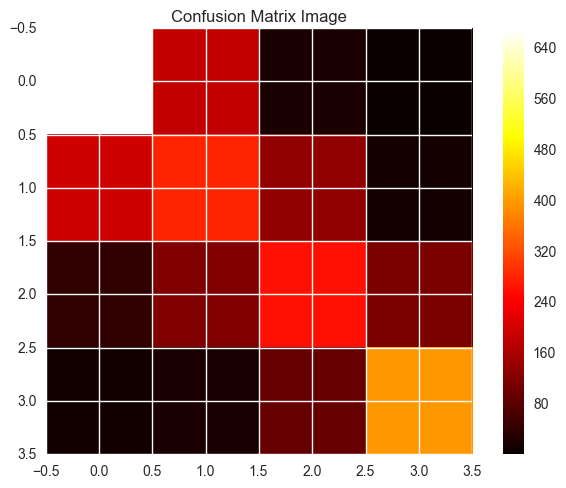

In [138]:
fc = filtered_by_thresholds[importances_thresholds.index(best_threshold)]
forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_leaf, oob_score=True)
forest.fit(rf_train_set[fc].values, rf_train_labels)
rf_train_predicted_probs = forest.predict_proba(rf_train_set[fc])
rf_test_predicted_probs = forest.predict_proba(rf_test_set[fc])
rf_test_predictions = forest.predict(rf_test_set[fc])
res = metrics.precision_score(rf_test_labels, rf_test_predictions, average='macro')
print "Random Forest test precision:", res

cm_rf_labels = rf_test_labels.apply(lambda x: x[-1])
cm_rf_predictions = [a[-1] for a in rf_test_predictions.tolist()]
m = confusion_matrix(cm_rf_labels.values, cm_rf_predictions)
plotConfusion(m, bin_num)

## LR - numrical predictions - DELETE ME

In [61]:
lr2_pp_data = all_data.copy()
lr2_pp_data.drop(categorical_variables, 1, inplace=True)
lr2_pp_data = lr2_pp_data[lr2_pp_data['likes'] > 50000]
lr2_pp_data = lr2_pp_data.sample(frac=1)

lr2_train_len = 1000
lr2_test_len = 100
lr2_labels = pp_data['likes']
lr2_ids = pp_data['id']

lr2_train_set = pp_data[:lr2_train_len].copy()
lr2_test_set = pp_data[lr2_train_len:lr2_train_len+lr2_test_len].copy()

lr2_train_labels = lr2_labels[:lr2_train_len].copy()
lr2_test_labels = lr2_labels[lr2_train_len:lr2_train_len+lr2_test_len].copy()

lr2_train_ids = lr2_ids[:lr2_train_len].copy()
lr2_test_ids = lr2_ids[lr2_train_len:lr2_train_len+lr2_test_len].copy()

lr2_train_set.drop(['likes', 'id'], 1, inplace=True)
lr2_test_set.drop(['likes', 'id'], 1, inplace=True)
lr2_set = lr2_train_set.append(lr2_test_set, ignore_index=True)

In [62]:
lr2 = lm.LogisticRegression(penalty='l1', C=10**(-3))  #penalty='l2' #dual=True) #lr_selceted_c)

print "training logistic regression"
lr2.fit(lr2_train_set, lr2_train_labels)

print "getting logistic regression predictions"
lr2_predictions = lr2.predict(lr2_set)

print "calculating logistic regression Performance on the test set:"
lr2.score(lr2_test_set, lr2_test_labels, sample_weight=None)

# lr2_train_predicted_probs = lr2_predicted_probs[:lr_train_len]
# lr2_test_predicted_probs = lr2_predicted_probs[lr_train_len:]

# lr2_train_predictions = lr2_predictions[:lr_train_len]
# lr2_test_predictions = lr2_predictions[lr_train_len:]

training logistic regression
getting logistic regression predictions
calculating logistic regression Performance on the test set:


0.0

In [63]:
predicted = lr2_predictions[lr2_train_len:]
actual = lr2_test_labels.values
ratio = np.divide(predicted * 1.0, actual)

print 'median: ', np.median(ratio)
print 'mean: ', ratio.mean()
print 'std: ', ratio.std()
print 'min: ', ratio.min()
print 'max: ', ratio.max()


median:  1.3370815948
mean:  1.61211175502
std:  1.40803569521
min:  0.0
max:  7.02683595441


<function matplotlib.pyplot.show>

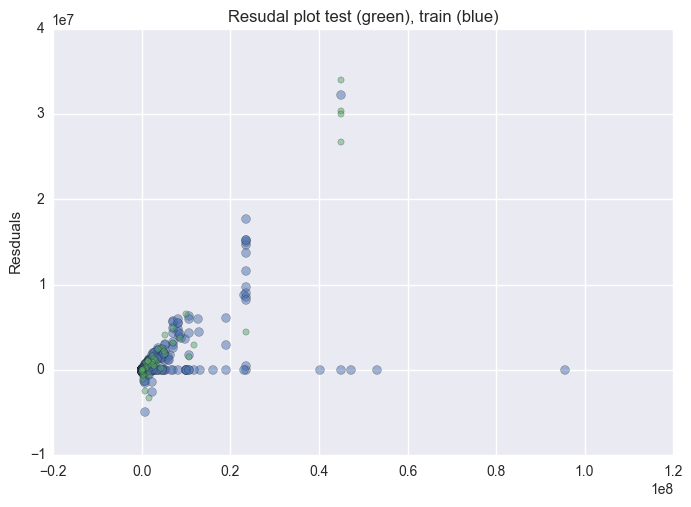

In [65]:
#TODO: add scatter plot predicted vs actual

plt.scatter(lr2_predictions[:lr2_train_len], lr2_predictions[:lr2_train_len] -  lr2_train_labels, c='b', s=40, alpha=0.5)
plt.scatter(lr2_predictions[lr2_train_len:], lr2_predictions[lr2_train_len:] -  lr2_test_labels, c='g', alpha=0.5)
plt.hlines(y=0, xmin=-10, xmax=50)
plt.title('Resudal plot test (green), train (blue)')
plt.ylabel('Resduals')
plt.show